   ####                               DSC 275/475: Time Series Analysis and Forecasting 		(Fall 2022)  
   ####                               Project 3.2 – LSTM-based Auto-encoders 
   ####                                              Total points: 50 
                                                
                                       
 ####                                      Submitted by: Aradhya Mathur and Lakshmi Nikhil Goduguluri
#### INSTRUCTIONS: <br>
•	You are welcome to work on this project individually or in teams (up to 2 members in each team max). <br>
•	If you plan to use PyTorch, a good resource is to review and modify the example code provided for the problem. We plan to review this example code in class as well. <br>
•	As outlined in the beginning of the code, you need to have the “arff2pandas” package to access the data files. 
For the submission, please make sure to hand in the following:  <br>
•	A document (PDF, Word etc) that captures your responses to the questions below separately from the code to facilitate grading. <br>
•	Your code files and output <br>
•	Both team members on team should please submit the work to Blackboard.<br>


#### Overview <br>
In this project, you will work with LSTM-based autoencoders to classify human heart beats for heart disease diagnosis. The dataset contains 5,000 Time Series examples with 140 timesteps. Each time-series is an ECG or EKG signal that corresponds to a single heartbeat from a single patient with congestive heart failure. An electrocardiogram (ECG or EKG) is a test that checks how your heart is functioning by measuring the electrical activity of the heart. With each heart beat, an electrical impulse (or wave) travels through your heart. This wave causes the muscle to squeeze and pump blood from the heart. There are 5 types of hearbeats (classes) that can be classified: i) Normal (N); ii) R-on-T Premature Ventricular Contraction (R-on-T PVC); iii) Premature Ventricular Contraction (PVC); iv) Supra-ventricular Premature or Ectopic Beat (SP or EB); v) Unclassified Beat (UB). The shape of the time-series and the position of the impulses allows doctors to diagnose these different conditions. For the purposes of this project, we are interested in 2 classes: Normal and Abnormal (which includes class 2-5 above merged).  <br>
This is an example of an anomaly detection problem where class imbalance exists, i.e. number of each of the individual positive (abnormal) instances are smaller than the normal case. The autoencoder approach is suited well for such applications of anomaly detection. In anomaly detection, we learn the pattern of a normal process. Anything that does not follow this pattern is classified as an anomaly. For a binary classification of rare events, we can use a similar approach using autoencoders. <br>
A sample code example (in Python) implementation of auto-encoder “AutoEncoders_anomaly_detection_ecg_SAMPLE.py” is provided. Review and run the code and answer the following questions: 


#### 1. A critical hyper-parameter when using auto-encoders is the threshold applied to the reconstructed time-series to classify between normal and abnormal. The default threshold in the code is set to 45. Run the code for 50 epochs.				


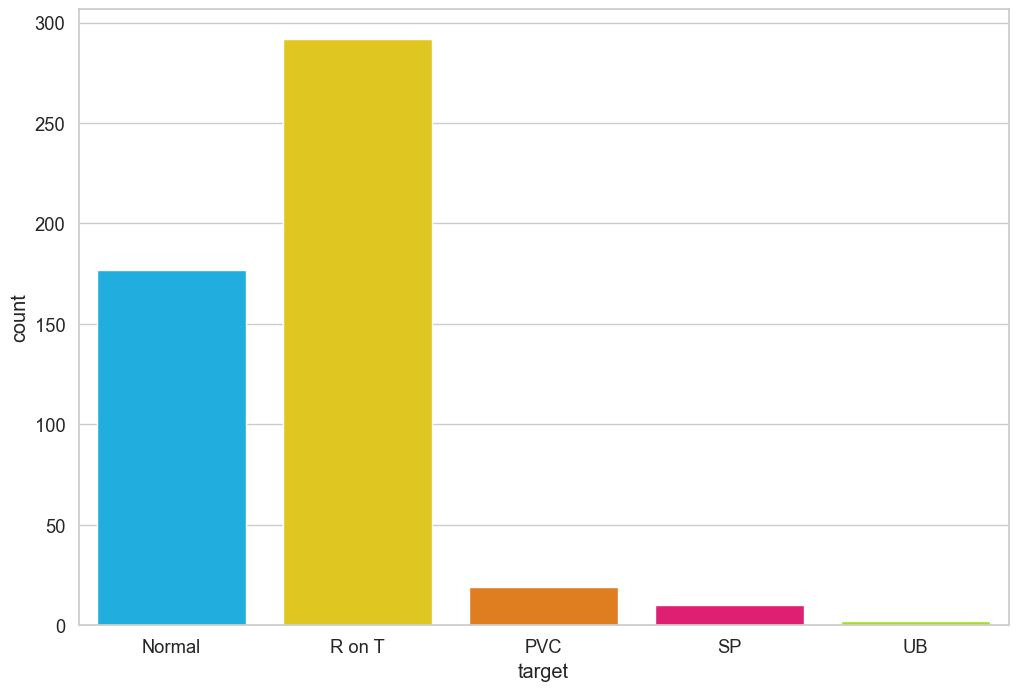

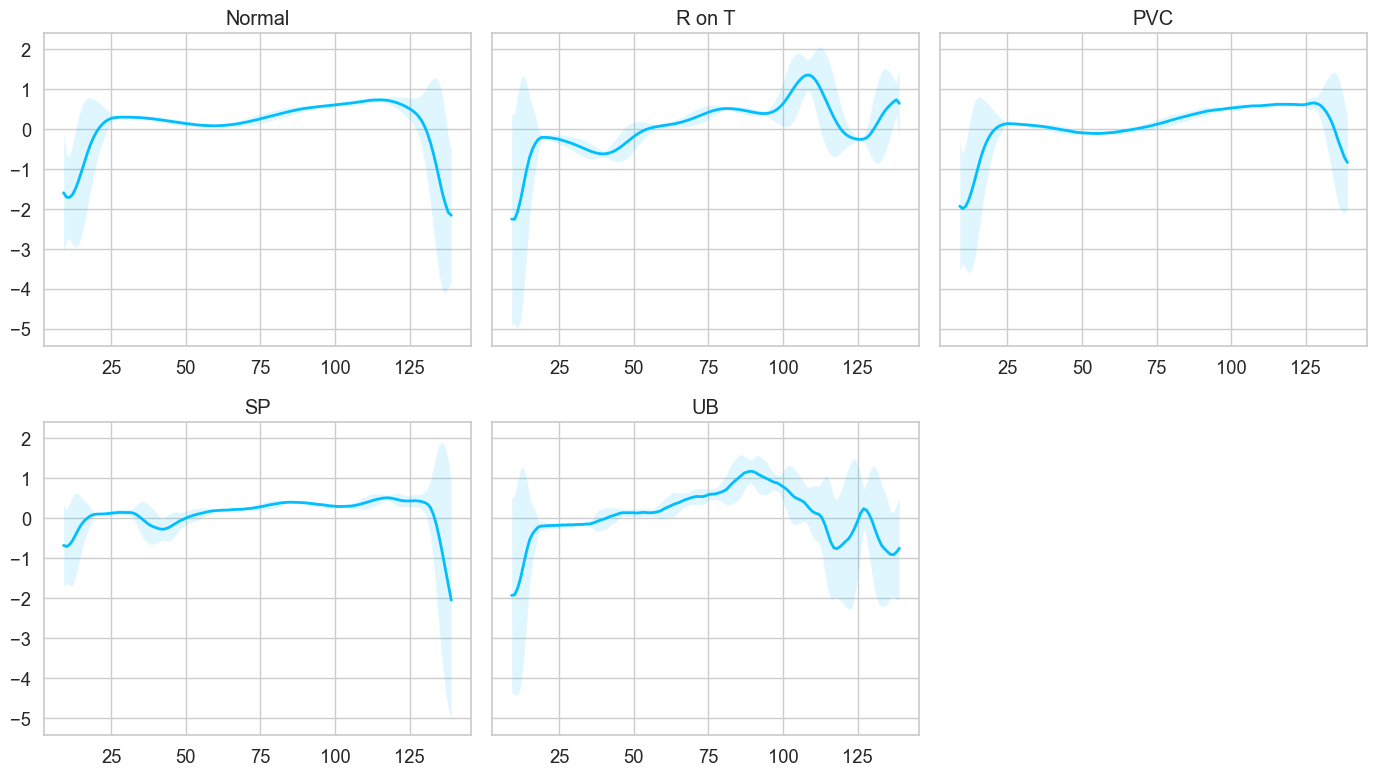

In [1]:
"""
# Time Series Anomaly Detection using LSTM Autoencoders with PyTorch in Python

# Uncomment the "pip" commands as necessary to install the packages

# Needed to access the data files
# !pip install -qq arff2pandas

# 
# !pip install -q -U watermark

# !pip install -qq -U pandas

# Commented out IPython magic to ensure Python compatibility.
# %reload_ext watermark
# %watermark -v -p numpy,pandas,torch,arff2pandas

# Commented out IPython magic to ensure Python compatibility.
"""
import torch
import warnings
warnings.filterwarnings('ignore')
import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split

from torch import nn, optim

import torch.nn.functional as F
#from arff2pandas import a2p
from scipy.io import arff

# %matplotlib inline
# %config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

"""
In this tutorial, you'll learn how to detect anomalies in Time Series data using an LSTM Autoencoder. 
You're going to use real-world ECG data from a single patient with heart disease to detect abnormal hearbeats.

# Data
The [dataset](http://timeseriesclassification.com/description.php?Dataset=ECG5000) contains 5,000 Time Series examples (obtained with ECG) with 140 timesteps. Each sequence corresponds to a single heartbeat from a single patient with congestive heart failure.

> An electrocardiogram (ECG or EKG) is a test that checks how your heart is functioning by measuring the electrical activity of the heart. With each heart beat, an electrical impulse (or wave) travels through your heart. This wave causes the muscle to squeeze and pump blood from the heart. [Source](https://www.heartandstroke.ca/heart/tests/electrocardiogram)

We have 5 types of hearbeats (classes):

- Normal (N) 
- R-on-T Premature Ventricular Contraction (R-on-T PVC)
- Premature Ventricular Contraction (PVC)
- Supra-ventricular Premature or Ectopic Beat (SP or EB) 
- Unclassified Beat (UB).

> Assuming a healthy heart and a typical rate of 70 to 75 beats per minute, each cardiac cycle, or heartbeat, takes about 0.8 seconds to complete the cycle.
Frequency: 60–100 per minute (Humans)
Duration: 0.6–1 second (Humans) [Source](https://en.wikipedia.org/wiki/Cardiac_cycle)
"""

#Load the arff files into Pandas data frames / Change Path as needed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train = arff.loadarff('ECG5000_TRAIN.arff')
test = arff.loadarff('ECG5000_TEST.arff')


#We'll combine the training and test data into a single data frame. This will give us more data to train our Autoencoder. We'll also shuffle it:"""

df = pd.DataFrame(train[0])
df = df.sample(frac=1.0)
df['target'] = df['target'].apply(lambda x: str(x.decode()))

df.head()

"""We have 5,000 examples. Each row represents a single heartbeat record. Let's name the possible classes:"""

CLASS_NORMAL = 1

class_names = ['Normal','R on T','PVC','SP','UB']

"""Next, we'll rename the last column to `target`, so its easier to reference it:"""

new_columns = list(df.columns)
new_columns[-1] = 'target'
df.columns = new_columns

"""## Exploratory Data Analysis

Let's check how many examples for each heartbeat class do we have:
"""

df.target.value_counts()

"""Let's plot the results:"""

ax = sns.countplot(df.target)
ax.set_xticklabels(class_names);

"""The normal class, has by far, the most examples. 

Let's have a look at an averaged (smoothed out with one standard deviation on top and bottom of it) Time Series for each class:
"""


classes = df.target.unique()

fig, axs = plt.subplots(
  nrows=len(classes) // 3 + 1,
  ncols=3,
  sharey=True,
  figsize=(14, 8)
)

def plot_time_series_class(data, class_name, ax, n_steps=10):
    time_series_df = pd.DataFrame(data)

    smooth_path = time_series_df.rolling(n_steps).mean()
    path_deviation = 2 * time_series_df.rolling(n_steps).std()

    under_line = (smooth_path - path_deviation)[0]
    over_line = (smooth_path + path_deviation)[0]

    ax.plot(smooth_path, linewidth=2)
    ax.fill_between(
        path_deviation.index,
        under_line,
        over_line,
        alpha=.125
      )
    ax.set_title(class_name)
    
def create_dataset(df):

    sequences = df.astype(np.float32).to_numpy().tolist()

    dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]

    n_seq, seq_len, n_features = torch.stack(dataset).shape

    return dataset, seq_len, n_features
def train_model(model, train_dataset, val_dataset, n_epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.L1Loss(reduction='sum').to(device)
    history = dict(train=[], val=[])

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10000.0
  
    for epoch in range(1, n_epochs + 1):
        model = model.train()

        train_losses = []
        for seq_true in train_dataset:
            optimizer.zero_grad()

            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)

            loss = criterion(seq_pred, seq_true)

            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

        val_losses = []
        model = model.eval()
        with torch.no_grad():
            for seq_true in val_dataset:

                seq_true = seq_true.to(device)
                seq_pred = model(seq_true)

                loss = criterion(seq_pred, seq_true)
                val_losses.append(loss.item())

        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)

        history['train'].append(train_loss)
        history['val'].append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

        print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

    model.load_state_dict(best_model_wts)
    return model.eval(), history


def predict(model, dataset):
    predictions, losses = [], []
    criterion = nn.L1Loss(reduction='sum').to(device)
    with torch.no_grad():
        model = model.eval()
        for seq_true in dataset:
            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)

            loss = criterion(seq_pred, seq_true)

            predictions.append(seq_pred.cpu().numpy().flatten())
            losses.append(loss.item())
    return predictions, losses

def plot_prediction(data, model, title, ax):
    predictions, pred_losses = predict(model, [data])

    ax.plot(data, label='true')
    ax.plot(predictions[0], label='reconstructed')
    ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
    ax.legend()

for i, cls in enumerate(classes):
    ax = axs.flat[i]
    data = df[df.target == cls] \
        .drop(labels='target', axis=1) \
        .mean(axis=0) \
        .to_numpy()
    plot_time_series_class(data, class_names[i], ax)

fig.delaxes(axs.flat[-1])
fig.tight_layout();
plt.show()

## LSTM Autoencoder

### Data Preprocessing

#Let's get all normal heartbeats and drop the target (class) column:

normal_df = df[df.target == str(CLASS_NORMAL)].drop(labels='target', axis=1)
normal_df.shape

#Merge all other classes and mark them as anomalies:"""

anomaly_df = df[df.target != str(CLASS_NORMAL)].drop(labels='target', axis=1)
anomaly_df.shape

#Split the normal examples into train, validation and test sets:"""

train_df, val_df = train_test_split(
  normal_df,
  test_size=0.15,
  random_state=RANDOM_SEED
)

val_df, test_df = train_test_split(
  val_df,
  test_size=0.33, 
  random_state=RANDOM_SEED
)

#Convert our examples into tensors, so we can use them to train our Autoencoder. 



#Each Time Series will be converted to a 2D Tensor in the shape *sequence length* x *number of features* (140x1 in our case).

#Create Train, Val and Test datasets:

train_dataset, seq_len, n_features = create_dataset(train_df)
val_dataset, _, _ = create_dataset(val_df)
test_normal_dataset, _, _ = create_dataset(test_df)
test_anomaly_dataset, _, _ = create_dataset(anomaly_df)




In [2]:
class Encoder(nn.Module):

    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(Encoder, self).__init__()

        self.seq_len, self.n_features = seq_len, n_features
        #self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim
        self.embedding_dim, self.hidden_dim = embedding_dim, embedding_dim

        self.rnn1 = nn.LSTM(
          input_size=n_features,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True
        )
    
    def forward(self, x):
        x = x.reshape((1, self.seq_len, self.n_features))

        #x, (_, _) = self.rnn1(x)
        x, (hidden_n, _) = self.rnn1(x)
        #x, (hidden_n, _) = self.rnn2(x)

        return hidden_n.reshape((self.n_features, self.embedding_dim))

"""The *Encoder* uses LSTM layers to compress the Time Series data input.
Next, we'll decode the compressed representation using a *Decoder*:
"""

class Decoder(nn.Module):

    def __init__(self, seq_len, input_dim=64, n_features=1):
        super(Decoder, self).__init__()

        self.seq_len, self.input_dim = seq_len, input_dim
        # self.hidden_dim, self.n_features = 2 * input_dim, n_features
        self.hidden_dim, self.n_features = input_dim, n_features

        self.rnn1 = nn.LSTM(
          input_size=input_dim,
          hidden_size=input_dim, 
          num_layers=1, 
          batch_first=True
        )

        # self.rnn2 = nn.LSTM(
        #   input_size=input_dim,
        #   hidden_size=self.hidden_dim,
        #   num_layers=1,
        #   batch_first=True
        # )

        self.output_layer = nn.Linear(self.hidden_dim, n_features)

    def forward(self, x):
        x = x.repeat(self.seq_len, self.n_features)
        x = x.reshape((self.n_features, self.seq_len, self.input_dim))

        x, (hidden_n, cell_n) = self.rnn1(x)
        #x, (hidden_n, cell_n) = self.rnn2(x)
        x = x.reshape((self.seq_len, self.hidden_dim))

        return self.output_layer(x)

#Our Decoder contains LSTM layer and an output layer that gives the final reconstruction.

#Time to wrap everything into an easy to use module:


class RecurrentAutoencoder(nn.Module):

    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(RecurrentAutoencoder, self).__init__()

        self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
        self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x

Epoch 1: train loss 93.68227432620141 val loss 91.94254855451912
Epoch 2: train loss 83.77408173776442 val loss 72.34329644564924
Epoch 3: train loss 72.82345501069099 val loss 68.25324472887763
Epoch 4: train loss 71.84243231434976 val loss 67.90020633565969
Epoch 5: train loss 71.71428572747016 val loss 70.45059717112574
Epoch 6: train loss 71.3341083065156 val loss 69.73531315244477
Epoch 7: train loss 70.79142530502811 val loss 68.86568977092874
Epoch 8: train loss 70.60199652948687 val loss 68.18588454147866
Epoch 9: train loss 70.45257640654042 val loss 67.57419165249529
Epoch 10: train loss 70.3329794791437 val loss 67.36354064941406
Epoch 11: train loss 70.22542347446564 val loss 67.28971639172784
Epoch 12: train loss 70.00658121416646 val loss 67.25195404578899
Epoch 13: train loss 69.85935455752957 val loss 67.14721232447131
Epoch 14: train loss 69.83173917954967 val loss 67.15933174922549
Epoch 15: train loss 69.6104850769043 val loss 67.08205584822029
Epoch 16: train loss 6

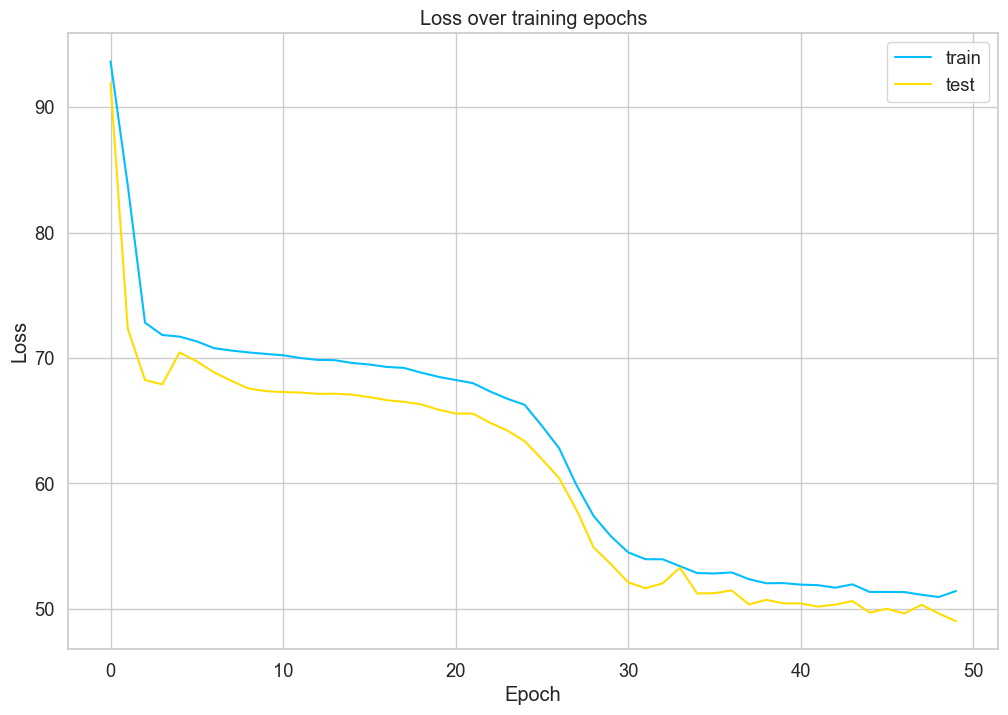

In [3]:
model = RecurrentAutoencoder(seq_len, n_features, 8)
model = model.to(device)

model, history = train_model(model, train_dataset,  val_dataset,  n_epochs=50 )
    
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

    ## Saving the model

    #Let's store the model for later use:


MODEL_PATH = 'model.pth'

torch.save(model, MODEL_PATH)

In [4]:
def question1(threshold):
    # LSTM Autoencoder
    #The general Autoencoder architecture consists of two components. An *Encoder* that compresses the input and a *Decoder* that tries to reconstruct it.

    _, losses = predict(model, train_dataset)

    sns.distplot(losses, bins=50, kde=True);

    THRESHOLD = threshold

    """## Evaluation

    Using the threshold, we can turn the problem into a simple binary classification task:

    - If the reconstruction loss for an example is below the threshold, we'll classify it as a *normal* heartbeat
    - Alternatively, if the loss is higher than the threshold, we'll classify it as an anomaly

    ### Normal hearbeats

    Let's check how well our model does on normal heartbeats. We'll use the normal heartbeats from the test set (our model haven't seen those):
    """

    predictions, pred_losses = predict(model, test_normal_dataset)
    sns.distplot(pred_losses, bins=50, kde=True);

    """We'll count the correct predictions:"""

    correct = sum(l <= THRESHOLD for l in pred_losses)
    print(f'Correct normal predictions: {correct}/{len(test_normal_dataset)}')
    
    normal_proportion = correct/len(test_normal_dataset)

    """### Anomalies

    We'll do the same with the anomaly examples, but their number is much higher. We'll get a subset that has the same size as the normal heartbeats:
    """

    anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]
    #anomaly_dataset = test_anomaly_dataset
    """Now we can take the predictions of our model for the subset of anomalies:"""

    predictions, pred_losses = predict(model, anomaly_dataset)
    sns.distplot(pred_losses, bins=50, kde=True);

    """Finally, we can count the number of examples above the threshold (considered as anomalies):"""

    correct = sum(l > THRESHOLD for l in pred_losses)
    print(f'Correct anomaly predictions: {correct}/{len(anomaly_dataset)}')
    
    anomaly_proportion = correct/len(anomaly_dataset)

    #### Looking at Examples

    #We can overlay the real and reconstructed Time Series values to see how close they are. We'll do it for some normal and anomaly cases:


    fig, axs = plt.subplots(
      nrows=2,
      ncols=6,
      sharey=True,
      sharex=True,
      figsize=(22, 8)
    )

    for i, data in enumerate(test_normal_dataset[:6]):
        plot_prediction(data, model, title='Normal', ax=axs[0, i])

    for i, data in enumerate(test_anomaly_dataset[:6]):
        plot_prediction(data, model, title='Anomaly', ax=axs[1, i])

    fig.tight_layout();
    
    return (normal_proportion, anomaly_proportion)

#### a)	For the normal and abnormal test set defined in the code as “test_normal_dataset” and “anomaly_dataset”, vary the threshold value from 15 to 75 (both included) in increments of 10 and report (as a graph or a table) the proportion of normal and abnormal time-series that were correctly classified, i.e. recall.	


In [5]:
proportions = []

Correct normal predictions: 0/15
Correct anomaly predictions: 15/15


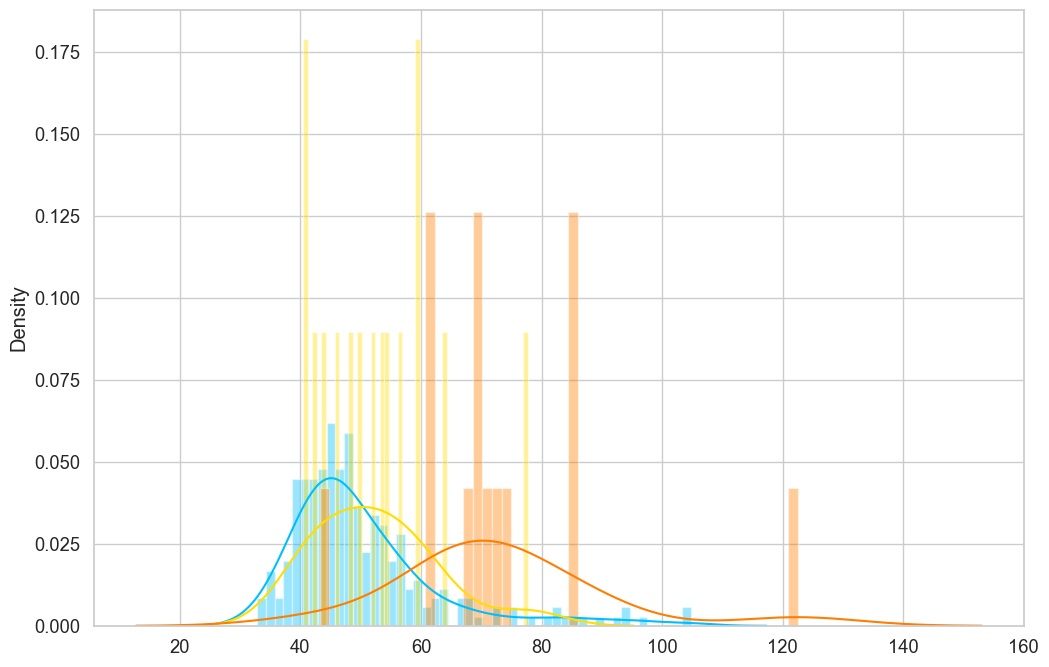

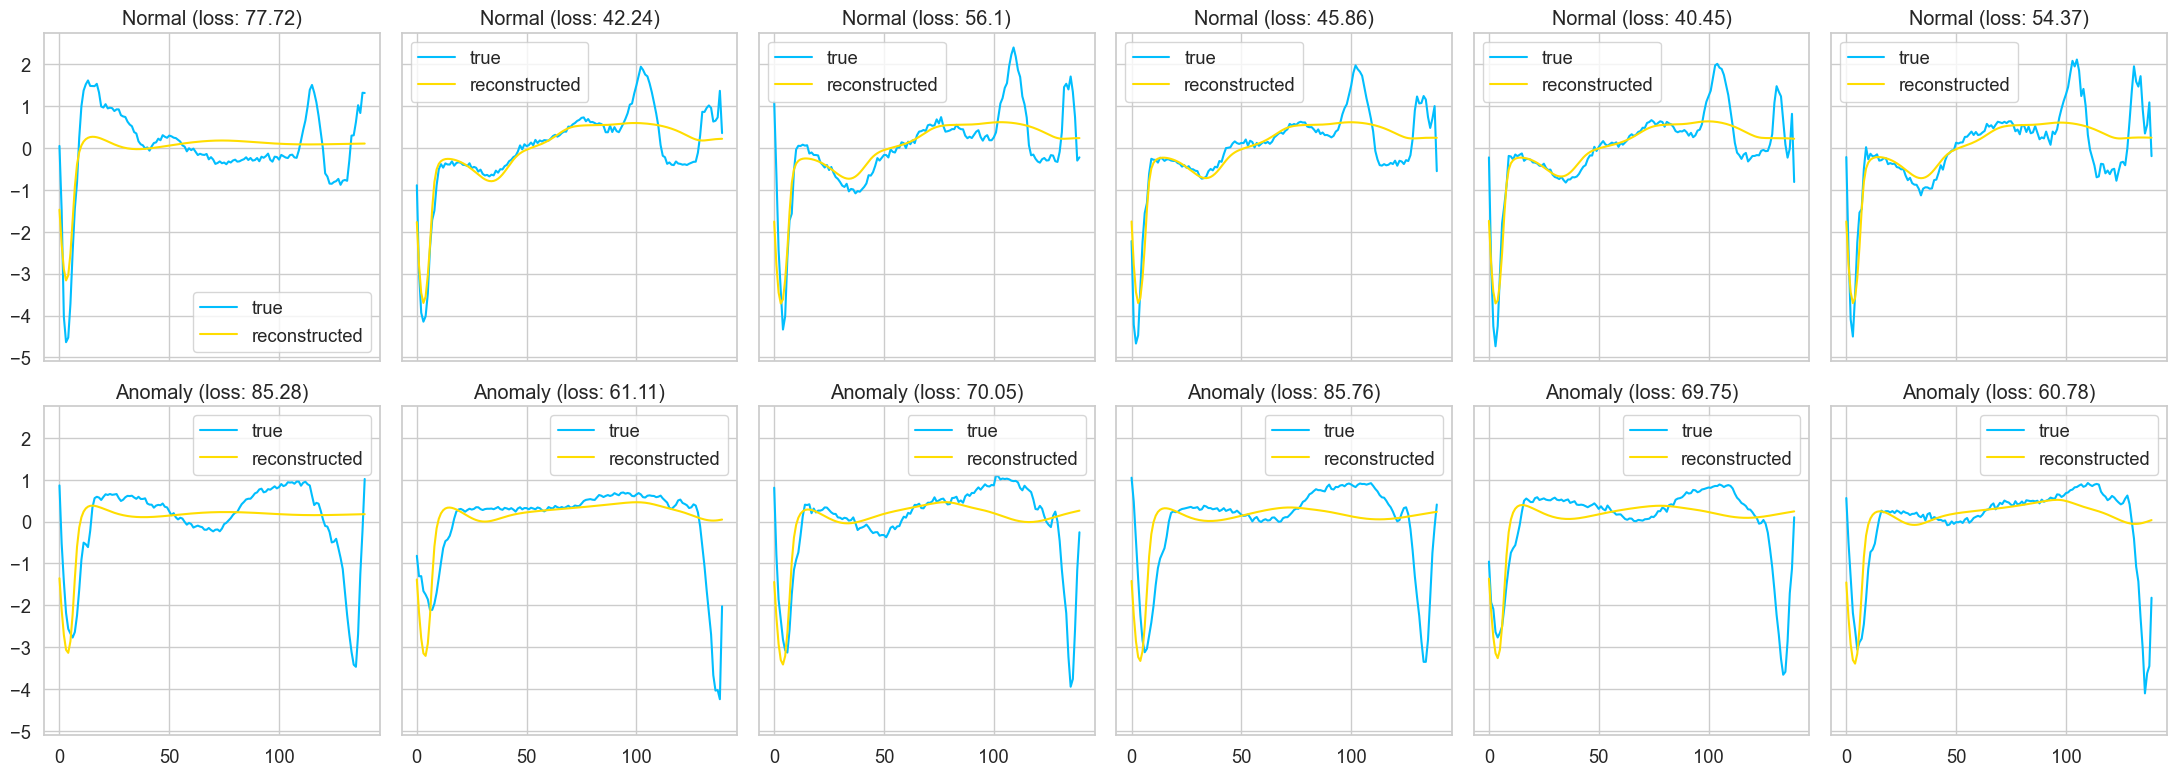

In [6]:
normal, anomaly = question1(15)
proportions.append([15, normal, anomaly])

Correct normal predictions: 0/15
Correct anomaly predictions: 15/15


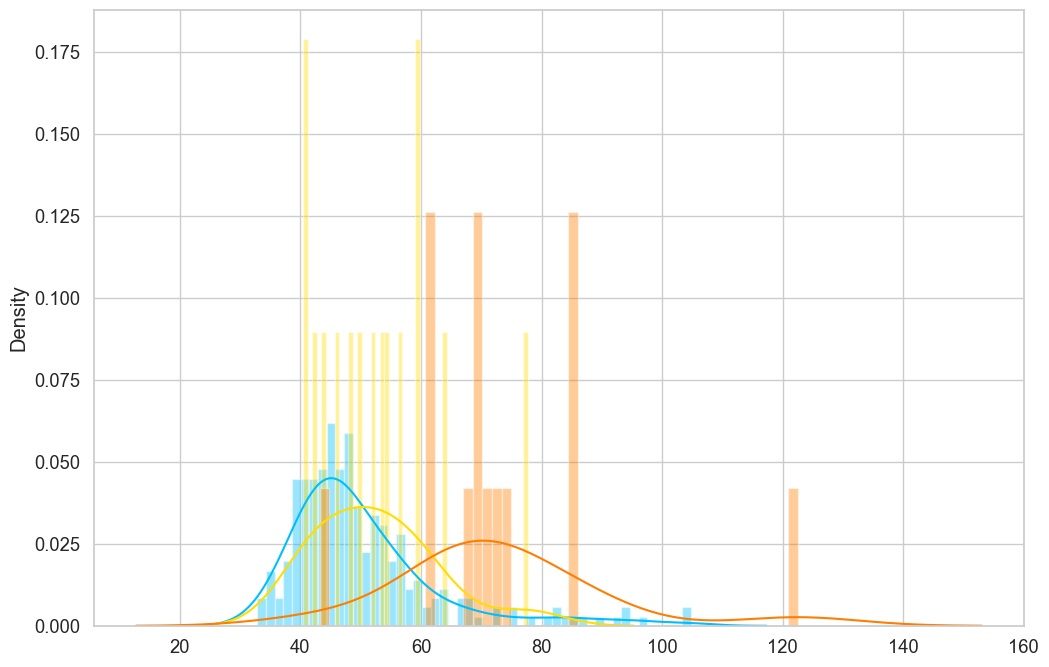

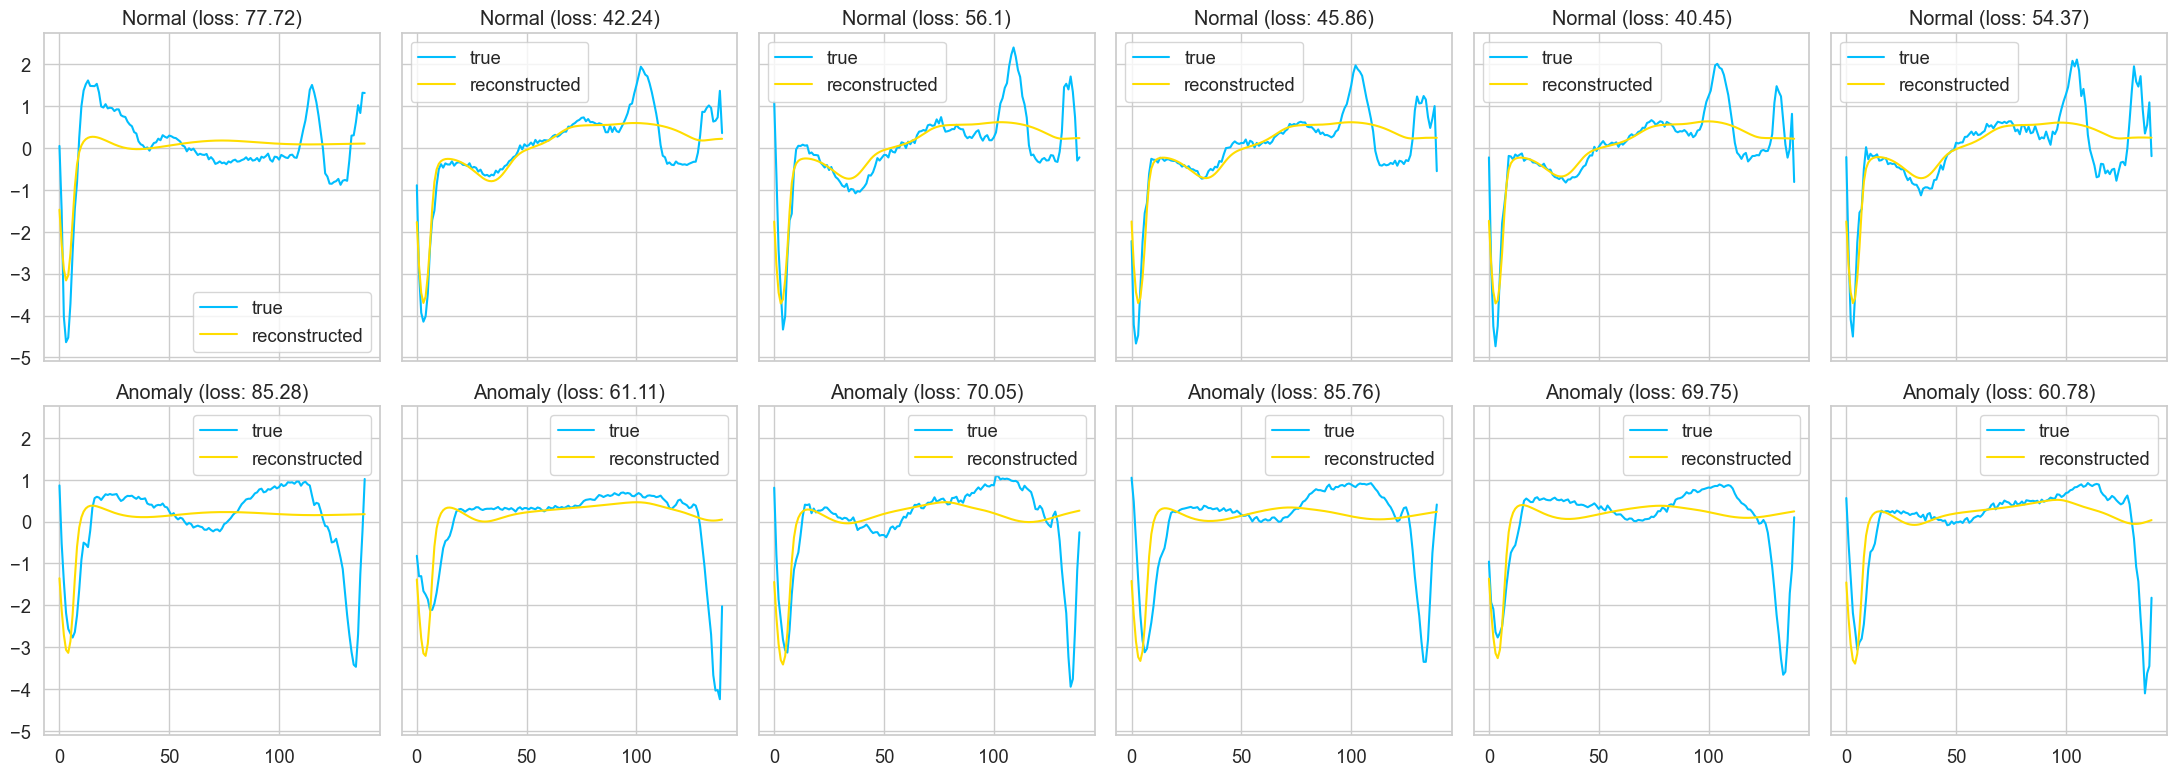

In [7]:
normal, anomaly = question1(25)
proportions.append([25, normal, anomaly])

Correct normal predictions: 0/15
Correct anomaly predictions: 15/15


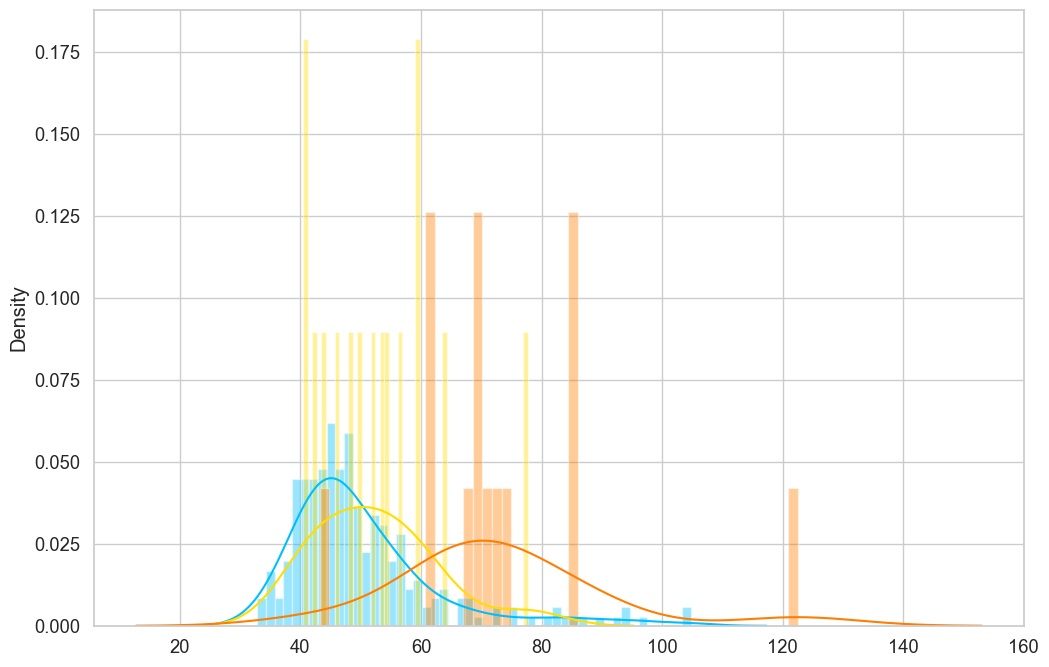

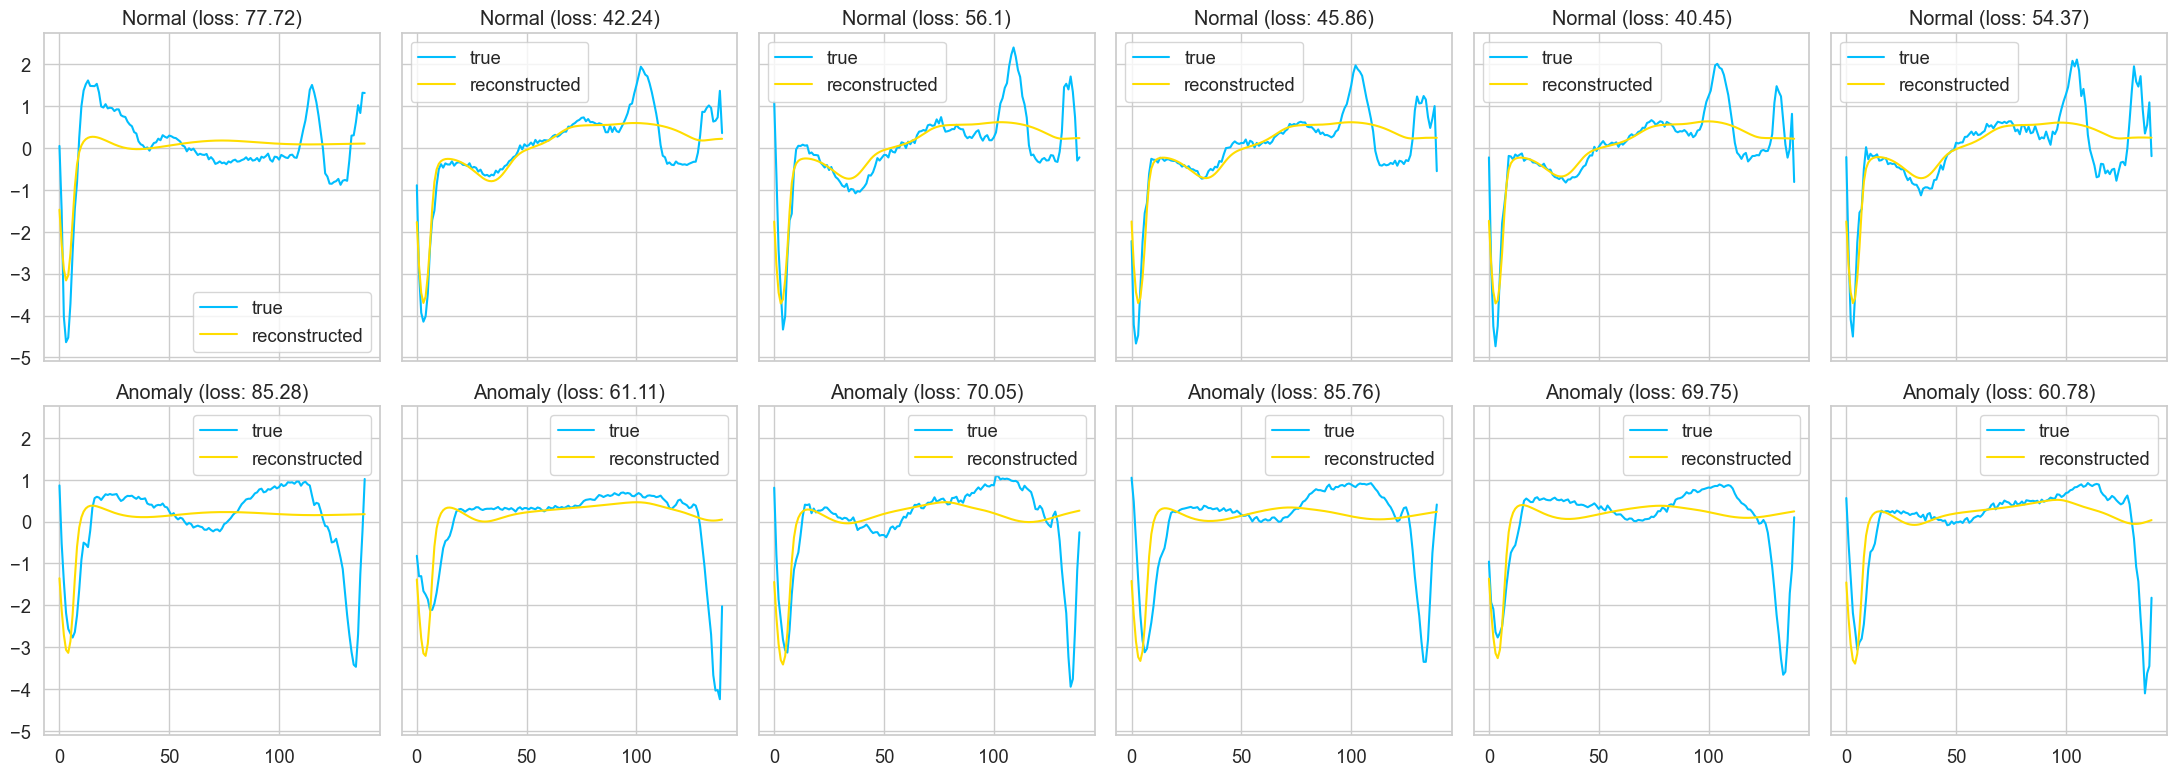

In [8]:
normal, anomaly = question1(35)
proportions.append([35, normal, anomaly])

Correct normal predictions: 4/15
Correct anomaly predictions: 14/15


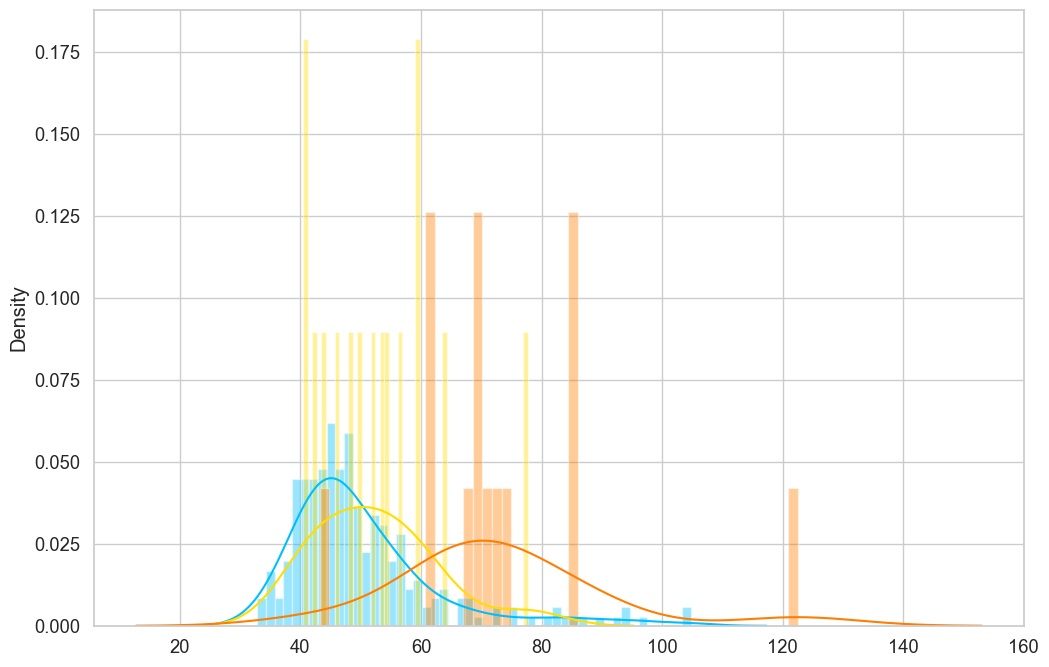

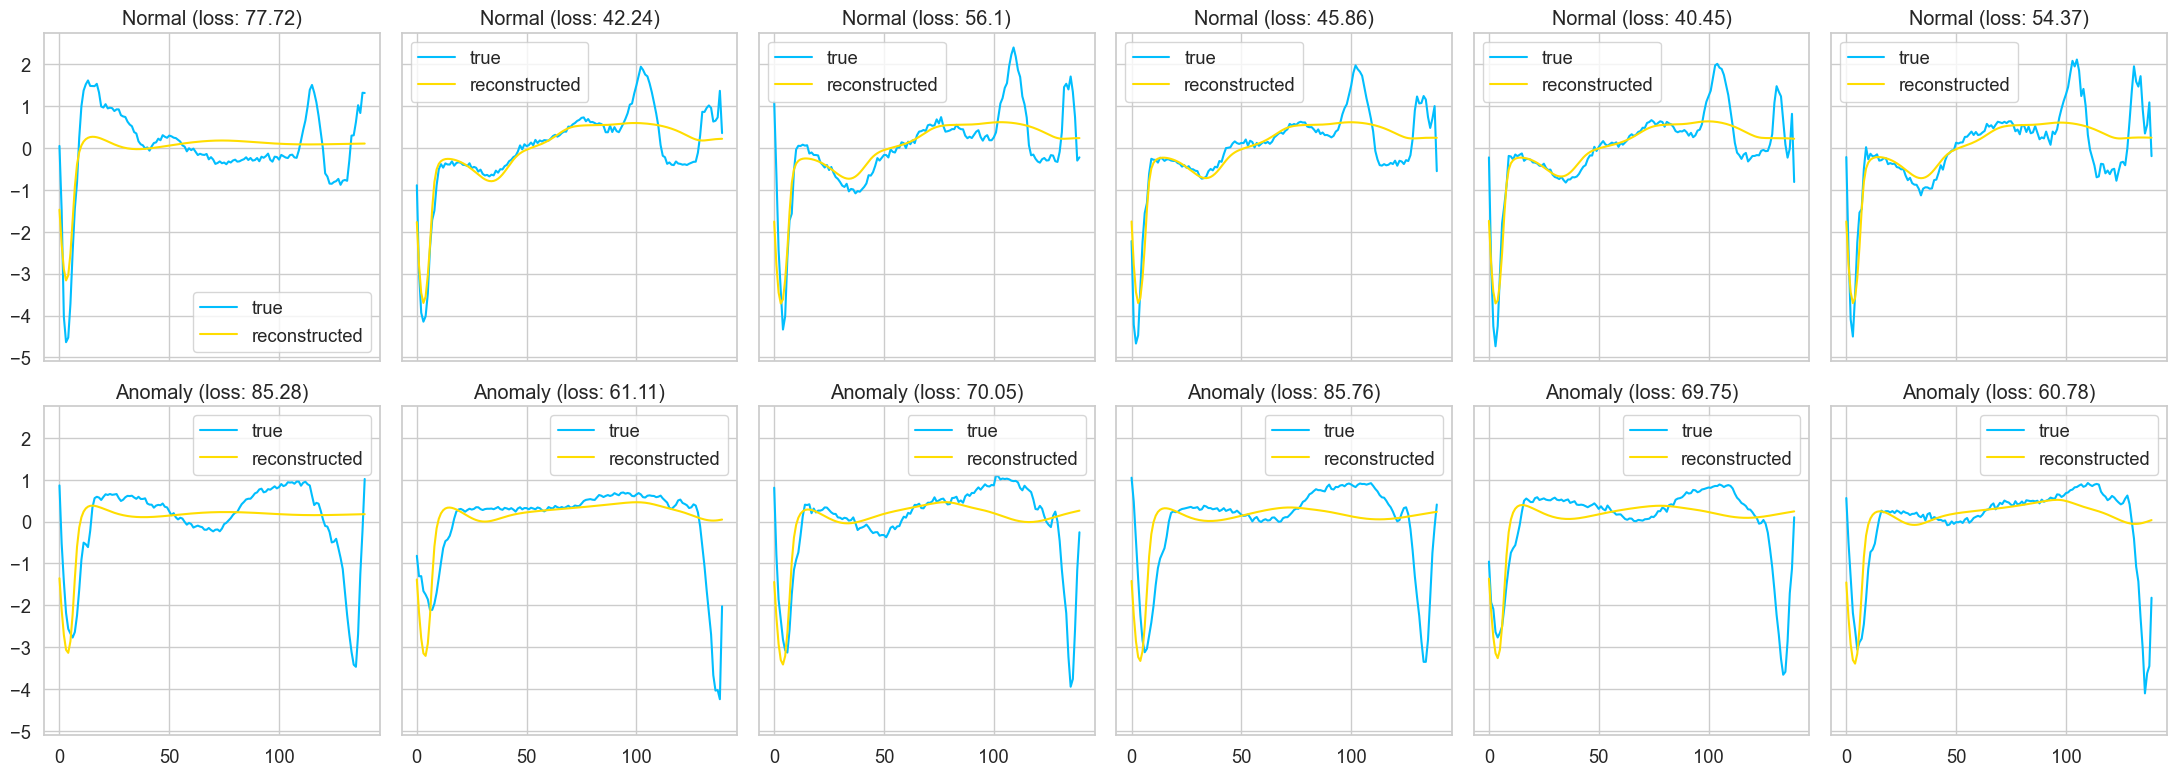

In [9]:
normal, anomaly = question1(45)
proportions.append([45, normal, anomaly])

Correct normal predictions: 10/15
Correct anomaly predictions: 14/15


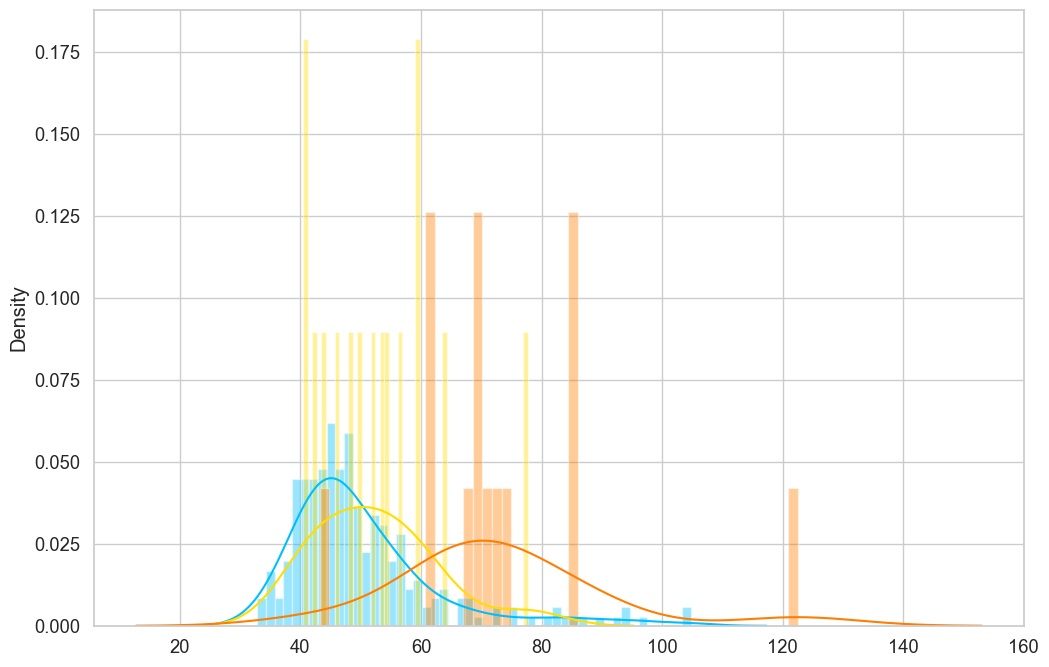

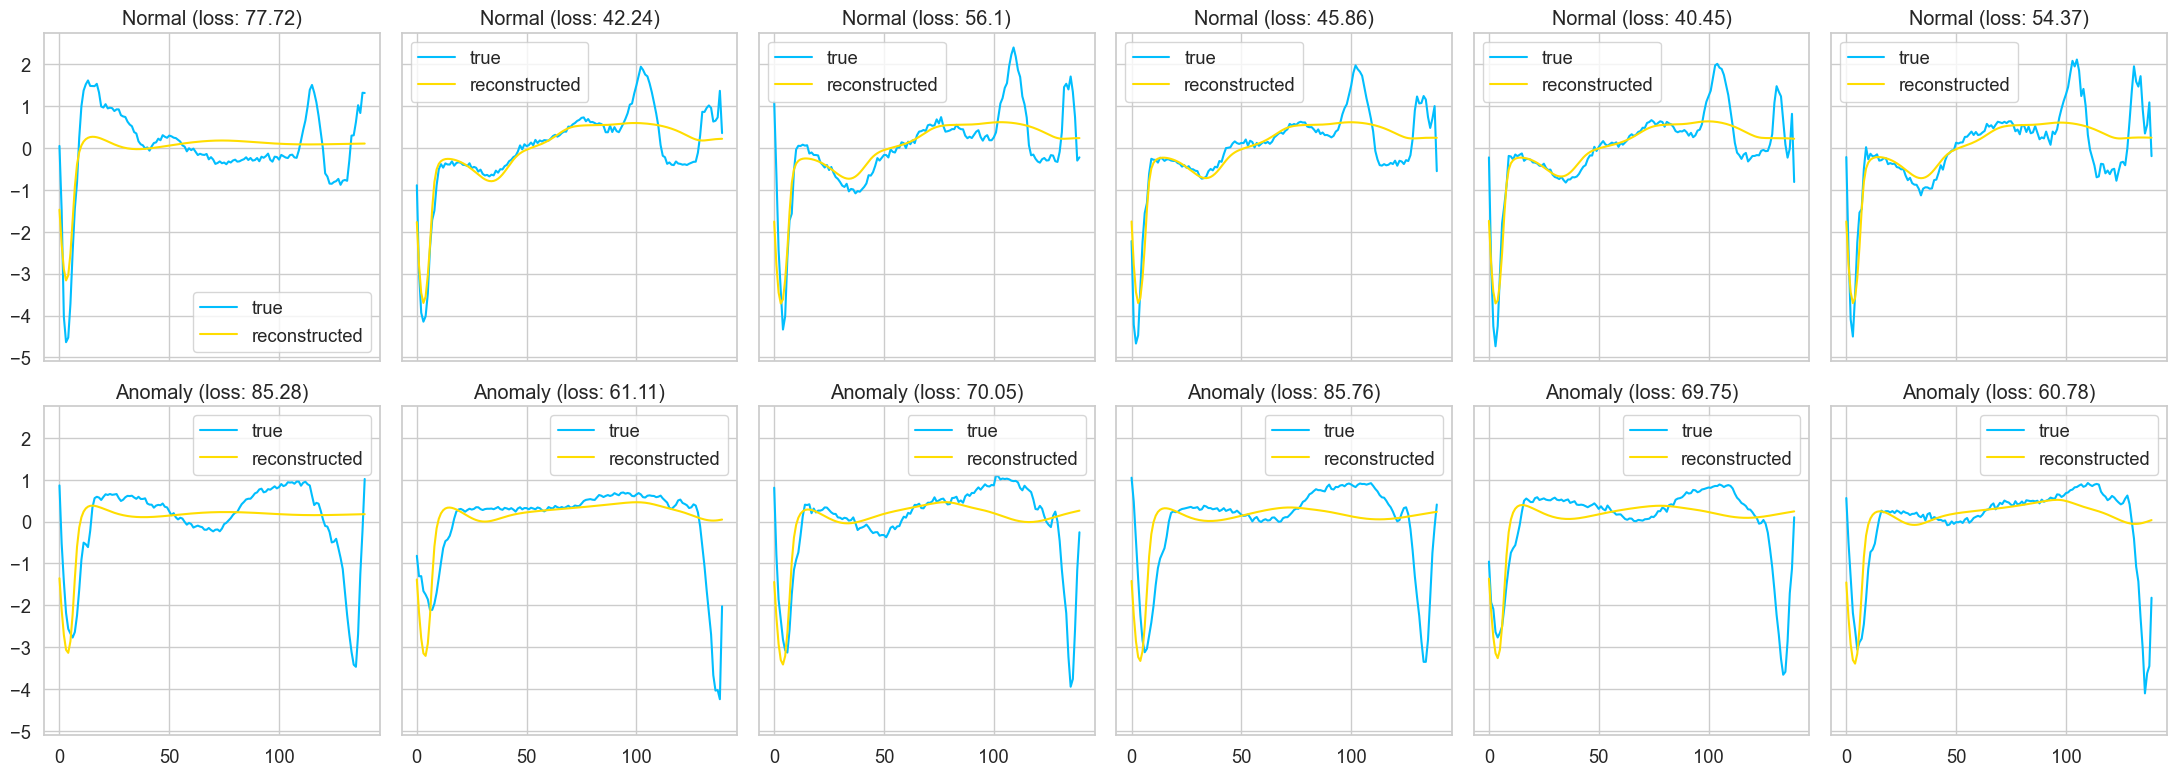

In [10]:
normal, anomaly = question1(55)
proportions.append([55, normal, anomaly])

Correct normal predictions: 14/15
Correct anomaly predictions: 11/15


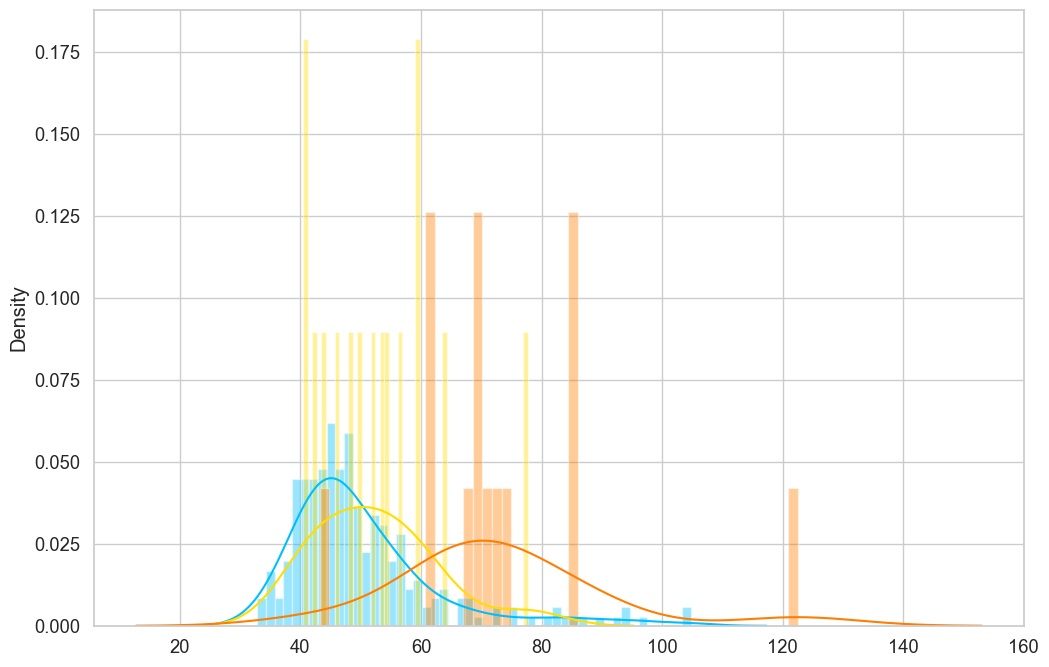

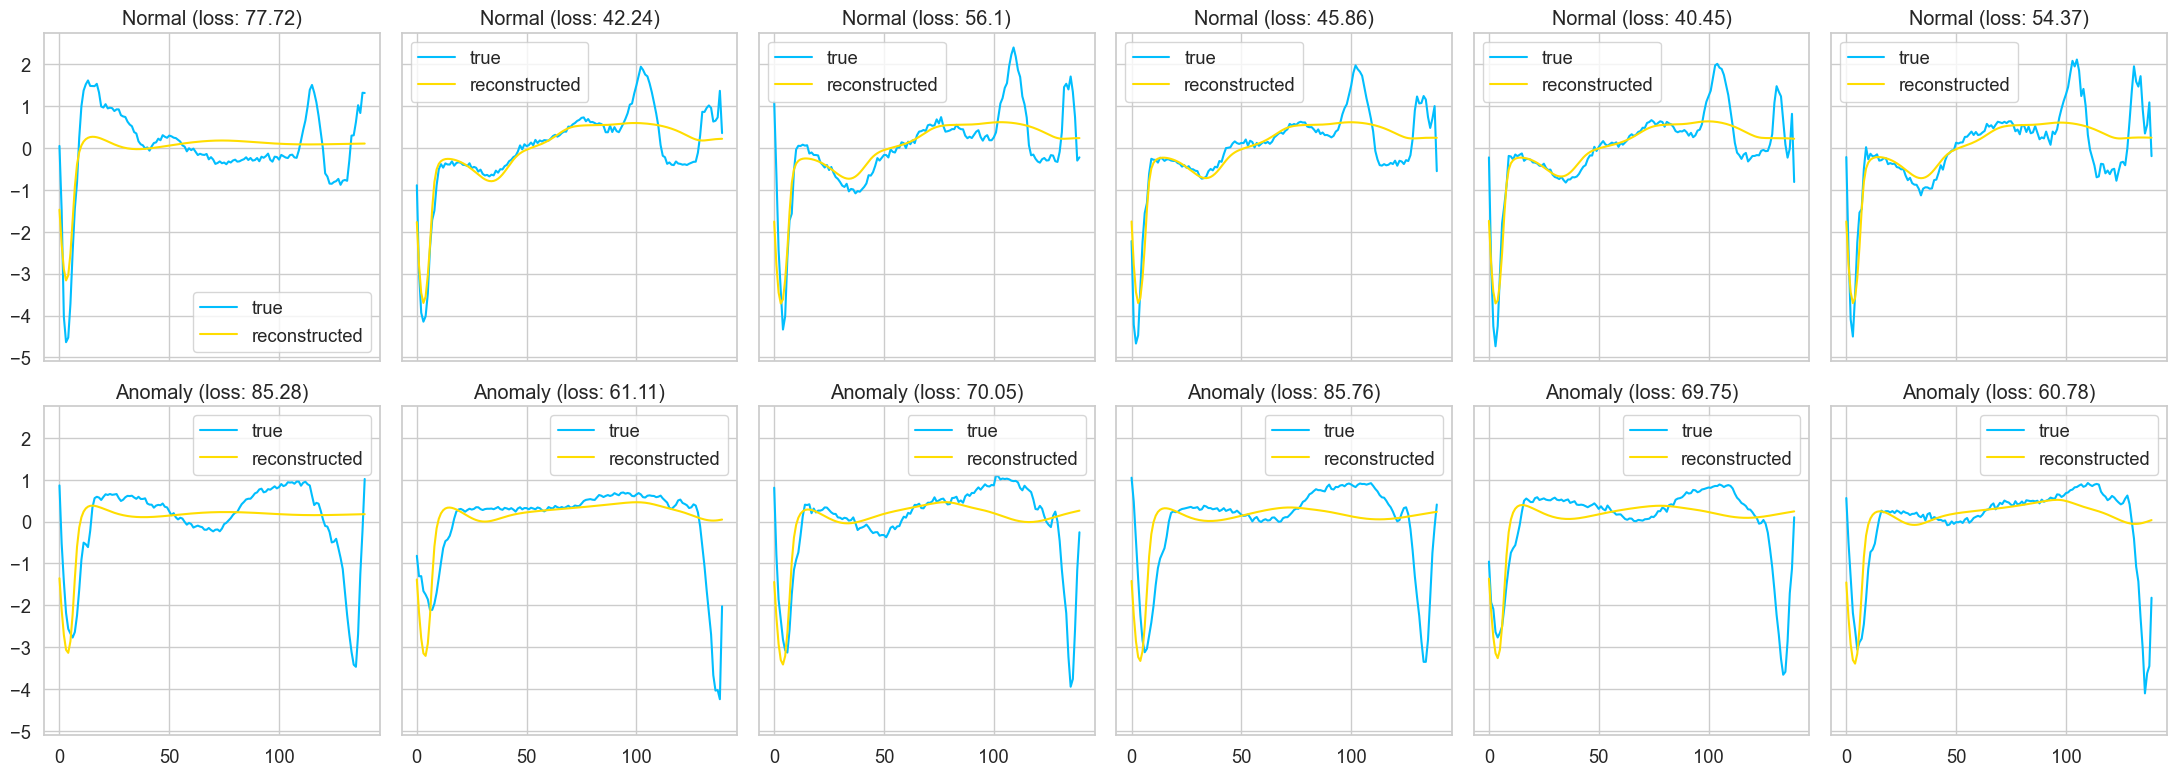

In [11]:
normal, anomaly = question1(65)
proportions.append([65, normal, anomaly])

Correct normal predictions: 14/15
Correct anomaly predictions: 4/15


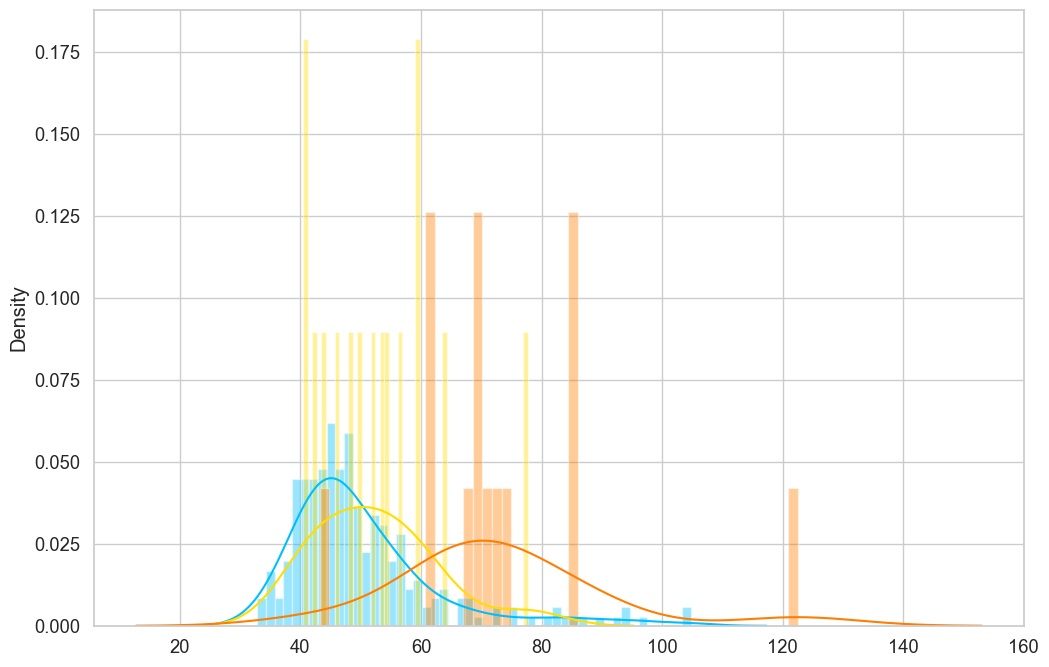

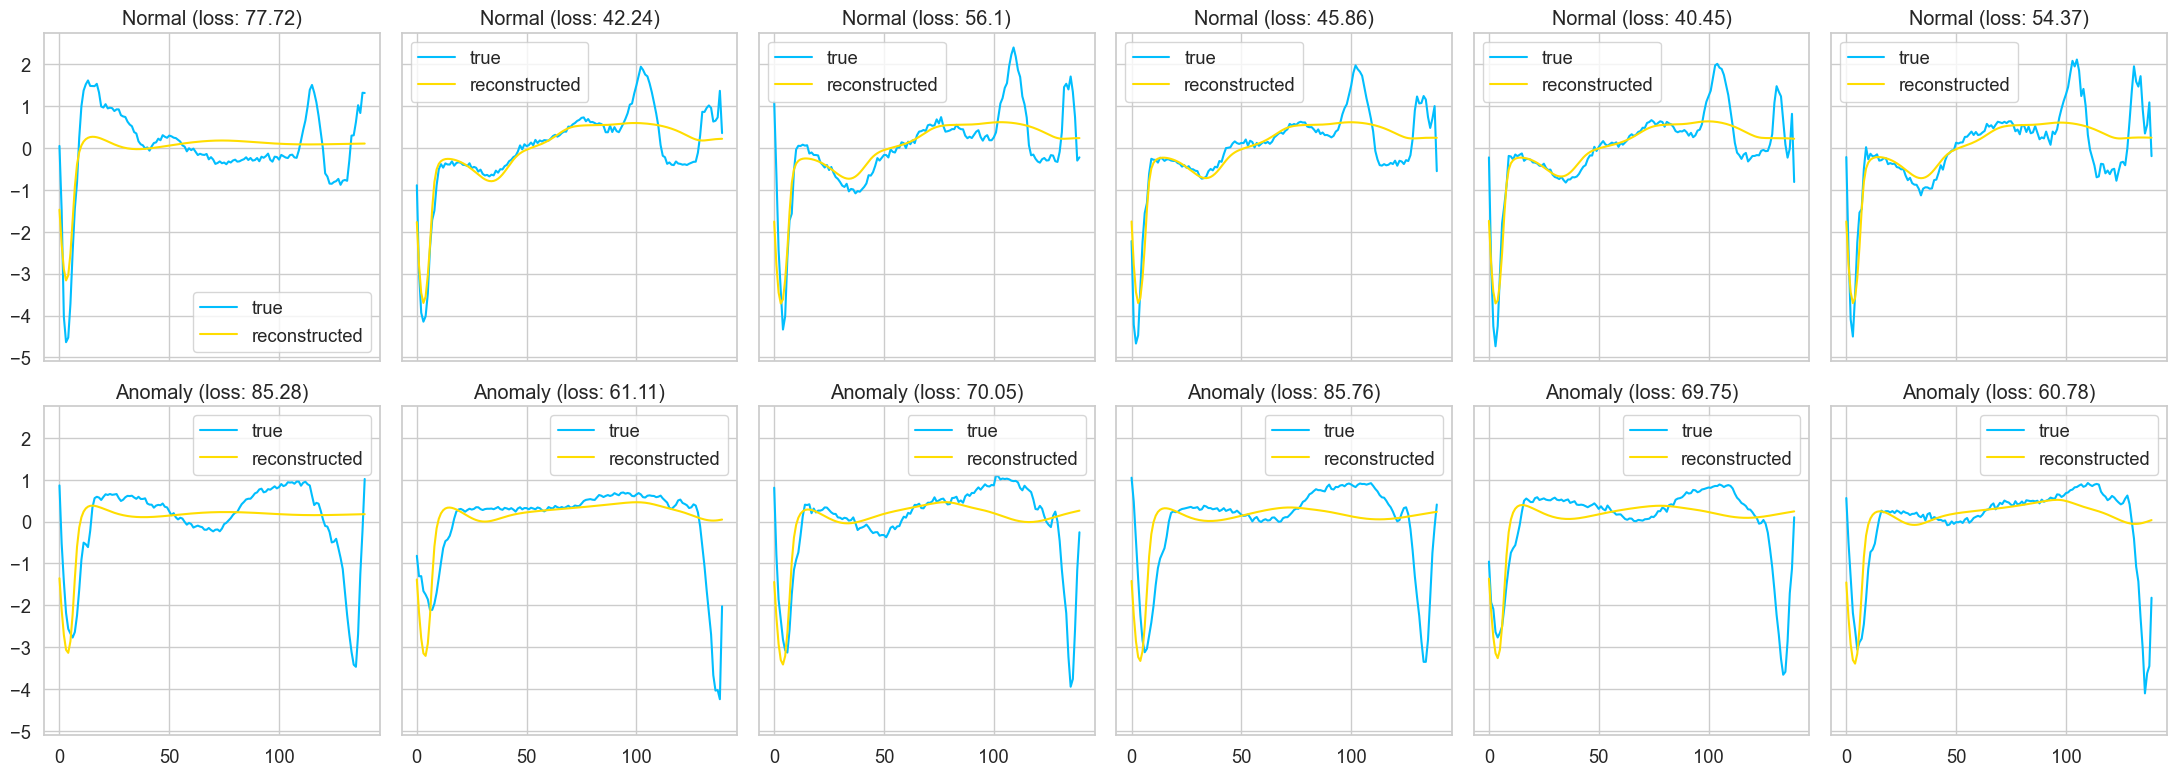

In [12]:
normal, anomaly = question1(75)
proportions.append([75, normal, anomaly])

In [15]:
proportions_df = pd.DataFrame(proportions, columns=['Threshold', 'Proportion of Normal', 'Proportion of Anomaly'])
proportions_df

,Threshold,Proportion of Normal,Proportion of Anomaly
0,15,0.000000,1.000000
1,25,0.000000,1.000000
2,35,0.000000,1.000000
3,45,0.266667,0.933333
4,55,0.666667,0.933333
5,65,0.933333,0.733333
6,75,0.933333,0.266667


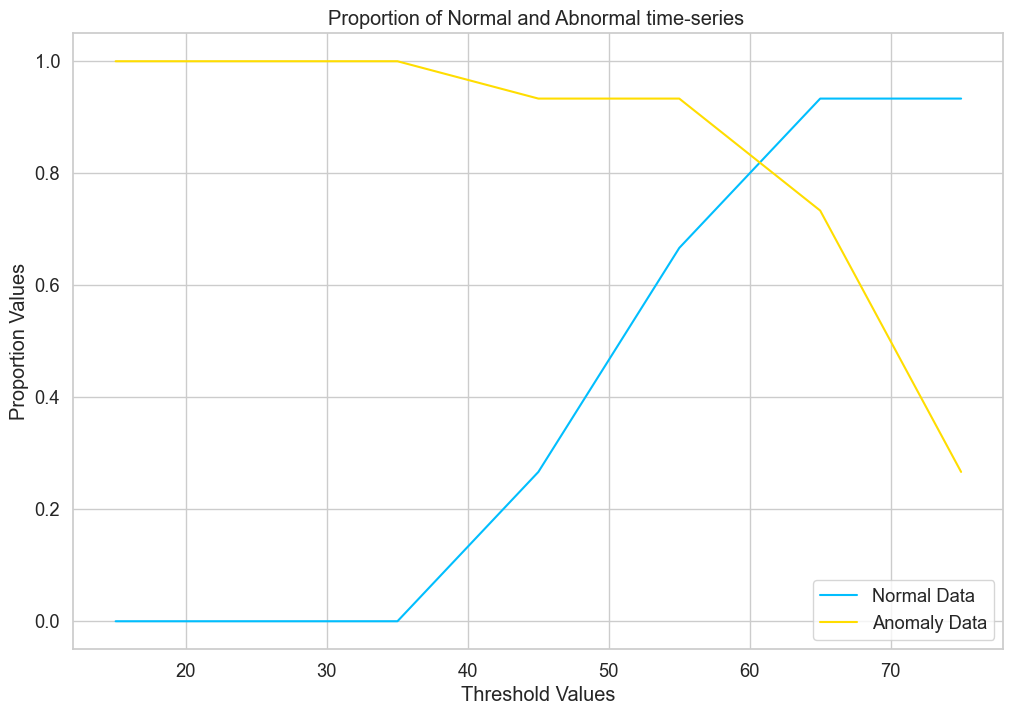

In [18]:
plt.plot(proportions_df['Threshold'], proportions_df['Proportion of Normal'], label='Normal Data')
plt.plot(proportions_df['Threshold'], proportions_df['Proportion of Anomaly'], label='Anomaly Data')
plt.title("Proportion of Normal and Abnormal time-series ")
plt.xlabel('Threshold Values')
plt.ylabel('Proportion Values')
plt.legend()
plt.show()

#### b)	Briefly explain the trend you see in the recall values as you increase the threshold.	

Answer) It is quite evident that the recall values shows increasing trend in case of correct proportion for Normal Data, while it shows  decreasing trend in case of correct proportion for Anomaly Data.